
# IMDB Dataset of 50K Movie Reviews




In this notebook, we perform a sentiment analysis on a Kaggle dataset of movie reviews. Here is the description from Kaggle:

> *IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.*


Our approach features a recurrent neural network with a long short-term memory (LSTM) cell. Step-by-step:

* Obtain the data from Kaggle.

* Split the data into train and test set as indicated (25K each).

* Preprocess the data by tokenizing words and forming a vocabulary.

* Form the LSTM neural network model.  

* Train the model using stochastic gradient descent.

* Evaluate the model on the test set.

We begin with standard imports:

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
import csv

## 1. Obtain the data from Kaggle

The first step is to obtain the data from Kaggle. This notebook is intended to be run in Google CoLab, so the first step is to mount google drive:

<!-- We follow the instructions on this [page](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a).  -->

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).



We set the Kaggle configuration directory to be where the kaggle.json token is located.

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'

Download the movie reviews data (this requires installation of the kaggle package via `pip install kaggle`, if necessary).


In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


Finally, copy the zip to the virtual machine and unzip it there.


In [5]:
zip_path = '/gdrive/MyDrive/kaggle/imdb-dataset-of-50k-movie-reviews.zip'
!cp '{zip_path}' .
!unzip -q 'imdb-dataset-of-50k-movie-reviews.zip'

replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


Check the working directory to see that the necessary files are there.


In [6]:
os.listdir()

['.config',
 'IMDB Dataset.csv',
 'imdb-dataset-of-50k-movie-reviews.zip',
 'sample_data']

## 2. Preprocessing

To process the data, the first step is to read the data into a pandas dataframe.

In [7]:
data = pd.read_csv("IMDB Dataset.csv", lineterminator='\n', converters={"review": str(), "sentiment": str()})

Next, we split the data into train and test sets. Following the description on Kaggle, the split is 50/50.


In [8]:
train_size = int(len(data)*0.5)
test_size = len(data) - train_size

Shuffle all the data (`fraction = 1`), and split the shuffled data into the train and test sets.

In [9]:
shuffled_data = data.sample(frac=1)
train_data, test_data = shuffled_data[:25000].copy(), shuffled_data[25000:].copy()
train_data

,review,sentiment
40330,I waited a long time to finally see what I tho...,negative
42873,foywonder's review of this cheap STV hits the ...,negative
8188,First I would like to say how great this. It i...,positive
35943,"I watch a lot of films, good, bad and indiffer...",positive
28972,I have to say that I really liked UNDER SIEGE ...,negative
...,...,...
25743,"Its not sophisticated, and nobody in the credi...",positive
30612,...and not in a good way. BASEketball is a was...,negative
2672,"In 'Hoot' Logan Lerman plays Roy Eberhardt, th...",positive
40884,I was very disappointed in this film. The dire...,negative


The `VocabFromReviews` encapsulates the main prepocessing steps. The words in the training data reviews constitute the tokens in our vocabulary. We order them by frequency and form a dictionary between indices and tokens. The `VocabFromReviews` class includes the method `process_and_convert_review_to_tensor` which uses the vocabulary to tokenize, index, and pad any pandas Series of reviews; it outputs a pytorch tensor.

In [10]:
from collections import Counter
import itertools
import re


class VocabFromReviews:
    """
    The Vocab takes a pd.Series of reviews, processes them into tokens by descending frequency, and creates dictionaries to move between tokens and indices
    """
    def __init__(self, reviews: pd.Series, min_freq: int = 0):
      tokenized_series = reviews.apply(
          lambda review_text : [self.preprocess_string(word) for word in review_text.split()]
      )
      tokenized_list = tokenized_series.to_list()
      tokens = list(itertools.chain.from_iterable(tokenized_list))
      counts = Counter(tokens)
      self.token_freqs = sorted(counts.items(), key=lambda x: x[1], reverse=True)
      self.idx_to_token = list(sorted(set(
          ['<unk>'] + [token for token, freq in self.token_freqs if freq >= min_freq])))
      self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def preprocess_string(self, s: str):
      """ Keep only words, and make them lower case. Remove breaks."""
      s = re.sub(r"[^\w\s]", '', s).lower()
      s = re.sub(r"\s+", '', s)
      s = re.sub(r"\d", '', s)
      if s == "br": return ""
      return s

    def __len__(self):
      return len(self.idx_to_token)

    def convert_tokenized_review_to_indices(self, single_tokenized_review : list):
      indices = []
      for token in single_tokenized_review:
          if token in self.token_to_idx and token:
              indices.append(self.token_to_idx[token])
      return indices


    def process_and_convert_review_to_tensor(self, input_reviews: pd.Series):
      """
      Take a pd.Series of reviews, tokenize, index according to the vocab dictionary, pad, and convert to a tensor
      """
      indexed_series = input_reviews.apply(
          lambda review_text :
            self.convert_tokenized_review_to_indices(
              [self.preprocess_string(word) for word in review_text.split()]
          )
      )
      max_length = indexed_series.apply(lambda l : len(l)).max()
      padded_indexed_series = indexed_series.apply(
        lambda review_indices : [0]*(max_length- len(review_indices)) + review_indices
      )
      return torch.tensor(padded_indexed_series.values.tolist())


We can now create the vocab from the training data.

In [11]:
vocab = VocabFromReviews(train_data["review"], min_freq=5)

Process the training data into padded indexed tokens.

In [12]:
train_features = vocab.process_and_convert_review_to_tensor(train_data["review"])
print(f"size of train features = {train_features.size()}")

size of train features = torch.Size([25000, 2360])


For the labels, encode a positive sentiment as 1 and a negative one as 0.

In [13]:
train_labels_pd = train_data["sentiment"].apply(lambda s: int(s == "positive"))
train_labels = torch.tensor(train_labels_pd.values.tolist()).unsqueeze(1).float()
print(f"size of train labels = {train_labels.size()}")

size of train labels = torch.Size([25000, 1])



## 3. Model

We now define the recurrent neural network model. The model is many-to-one since we input a tokenized string but output only a single value (positive/negative). Hence, we use a hidden recurrent neural network that outputs a single value at the end, and this value is plugged into a fully connected neural network.

In [14]:
class RNNHidden(nn.Module):
    def __init__(self, num_layers, input_dim, embedding_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first = True)

    def forward(self, text):

        #text.size() = (batch size, length of sequence)
        embedded = self.embedding(text)

        #embedded.size() = (batch_size, length of sequence)
        _, hidden = self.lstm(embedded)

        # Since this is a Many-to-One model, return only the last output
        return hidden[-1][0]

In [15]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 1
HIDDEN_LAYERS = 2

lstm_model = nn.Sequential(
    RNNHidden(HIDDEN_LAYERS, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM),
    nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
    nn.Dropout(p=0.5)
)
print(lstm_model)

Sequential(
  (0): RNNHidden(
    (embedding): Embedding(31536, 100)
    (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  )
  (1): Linear(in_features=64, out_features=1, bias=True)
  (2): Dropout(p=0.5, inplace=False)
)


## 4. Training

Before training, we check is there is a GPU available. If so, the device will be the GPU.

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Next, define a binary accuracy function for evaluation.

In [17]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

We arrive at the training loop for the network.

In [18]:
import tqdm

def train(model, dataloader, optimizer, criterion, num_epochs, verbose=False):

    # Keep track of the loss and accuracy over the epochs
    train_loss = []
    train_acc = []

    model.train()
    for i in tqdm.tqdm(range(num_epochs)):
      for features, labels  in dataloader:

        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append(acc.item())

      if verbose:
        if (i+1) % 10 == 0:
          print(f"Epoch {i+1}: loss = {round(train_loss[-1],4)}, accuracy = {round(train_acc[-1],4)}")

    return train_loss, train_acc

Define a Dataset class for the review data. This is so that we can use the dataloader to create batches automatically.

In [19]:
from torch.utils.data import Dataset

class MovieReviewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

From the training dataset and the training dataloader.

In [20]:
train_dataset = MovieReviewsDataset(train_features.to(device), train_labels.to(device))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Use a stochastic gradient descent optimzer. The loss function is the binary cross entropy combined with sigmoid.

In [21]:
criterion = nn.BCEWithLogitsLoss().to(device)
lstm_model = lstm_model.to(device)
optimizer = optim.SGD(lstm_model.parameters(), lr=1e-3)

We finally get to training the model!

In [28]:
loss, acc = train(lstm_model, train_loader,
    optimizer=optimizer, criterion=criterion, num_epochs=200, verbose=True)

  5%|▌         | 10/200 [02:07<40:09, 12.68s/it]

Epoch 10: loss = 0.6921, accuracy = 0.525


 10%|█         | 20/200 [04:14<37:59, 12.66s/it]

Epoch 20: loss = 0.6735, accuracy = 0.6


 15%|█▌        | 30/200 [06:20<35:44, 12.62s/it]

Epoch 30: loss = 0.6585, accuracy = 0.6


 20%|██        | 40/200 [08:26<33:37, 12.61s/it]

Epoch 40: loss = 0.6707, accuracy = 0.525


 25%|██▌       | 50/200 [10:32<31:31, 12.61s/it]

Epoch 50: loss = 0.6724, accuracy = 0.55


 30%|███       | 60/200 [12:38<29:24, 12.60s/it]

Epoch 60: loss = 0.7034, accuracy = 0.425


 35%|███▌      | 70/200 [14:44<27:18, 12.60s/it]

Epoch 70: loss = 0.6559, accuracy = 0.6


 40%|████      | 80/200 [16:50<25:12, 12.60s/it]

Epoch 80: loss = 0.6835, accuracy = 0.525


 45%|████▌     | 90/200 [18:56<23:10, 12.64s/it]

Epoch 90: loss = 0.6689, accuracy = 0.525


 50%|█████     | 100/200 [21:03<21:03, 12.64s/it]

Epoch 100: loss = 0.7304, accuracy = 0.425


 55%|█████▌    | 110/200 [23:09<18:53, 12.60s/it]

Epoch 110: loss = 0.7115, accuracy = 0.5


 60%|██████    | 120/200 [25:15<16:49, 12.61s/it]

Epoch 120: loss = 0.6732, accuracy = 0.575


 65%|██████▌   | 130/200 [27:21<14:43, 12.62s/it]

Epoch 130: loss = 0.6848, accuracy = 0.625


 70%|███████   | 140/200 [29:27<12:35, 12.60s/it]

Epoch 140: loss = 0.6715, accuracy = 0.625


 75%|███████▌  | 150/200 [31:33<10:30, 12.61s/it]

Epoch 150: loss = 0.6901, accuracy = 0.475


 80%|████████  | 160/200 [33:39<08:24, 12.62s/it]

Epoch 160: loss = 0.6509, accuracy = 0.675


 85%|████████▌ | 170/200 [35:45<06:18, 12.61s/it]

Epoch 170: loss = 0.6939, accuracy = 0.4


 90%|█████████ | 180/200 [37:51<04:12, 12.62s/it]

Epoch 180: loss = 0.6833, accuracy = 0.425


 95%|█████████▌| 190/200 [39:57<02:06, 12.61s/it]

Epoch 190: loss = 0.6746, accuracy = 0.5


100%|██████████| 200/200 [42:03<00:00, 12.62s/it]

Epoch 200: loss = 0.704, accuracy = 0.45


Now plot how the accuracy and loss change over the course of training.

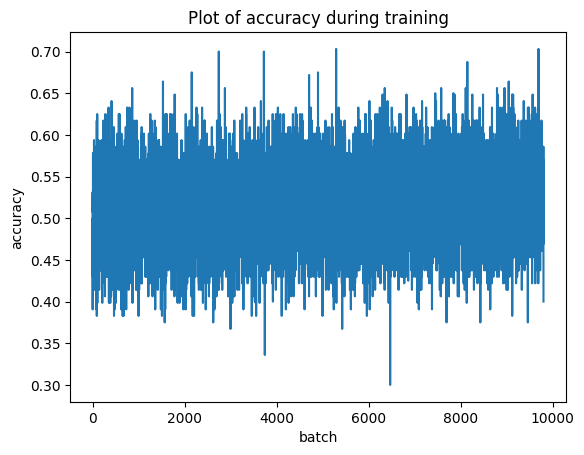

In [23]:
plt.plot(acc)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.title("Plot of accuracy during training")
plt.show()

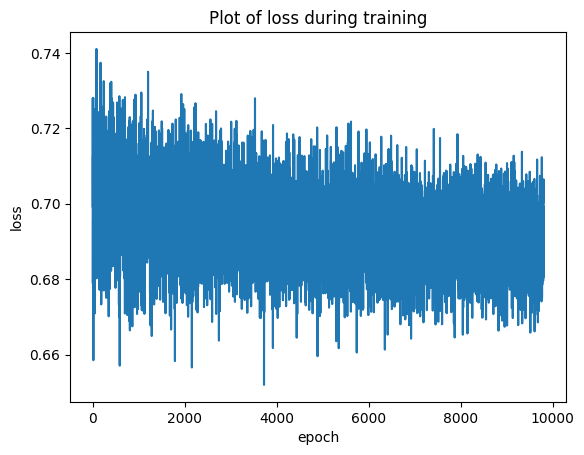

In [24]:
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Plot of loss during training")
plt.show()

### Evaluation

Finally, evaluate the model on the test set. We first have the evaluation function:

In [25]:
def evaluate(model, features, labels, criterion, verbose=False):
    model.eval()
    with torch.no_grad():
        predictions = model(features)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
    if verbose:
      print(f"The test loss is {round(loss.item(), 4)}")
      print(f"The test accuracy is {round(acc.item(), 4)}")
    return loss , acc

Next, we obtain the test features and labels.

In [26]:
test_features = vocab.process_and_convert_review_to_tensor(test_data["review"])
print(f"size of test features = {test_features.size()}")

test_labels_pd = test_data["sentiment"].apply(lambda s: int(s == "positive"))
test_labels = torch.tensor(test_labels_pd.values.tolist()).unsqueeze(1).float()
print(f"size of test labels = {test_labels.size()}")

size of test features = torch.Size([25000, 2151])
size of test labels = torch.Size([25000, 1])


Finally, evaluate the model on the test set. We need to do this with only part of the data at a time to keep within the GPU capacity.

In [27]:
test_loss_list = []
test_acc_list = []
i = 0
while i+500 < len(test_features):
  test_loss, test_acc = evaluate(
    model= lstm_model,
    features= test_features[i:i+500].to(device),
    labels = test_labels[i:i+500].to(device),
    criterion=criterion,
    verbose = False
  )
  test_loss_list.append(test_loss.item())
  test_acc_list.append(test_acc.item())
  i += 500

mean_loss = sum(test_loss_list)/ len(test_loss_list)
mean_acc = sum(test_acc_list)/ len(test_acc_list)

print(f"The test loss is {round(mean_loss, 4)}")
print(f"The test accuracy is {round(mean_acc, 4)}")


The test loss is 0.6884
The test accuracy is 0.5417
